In [21]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

8 classes with 302 images in total


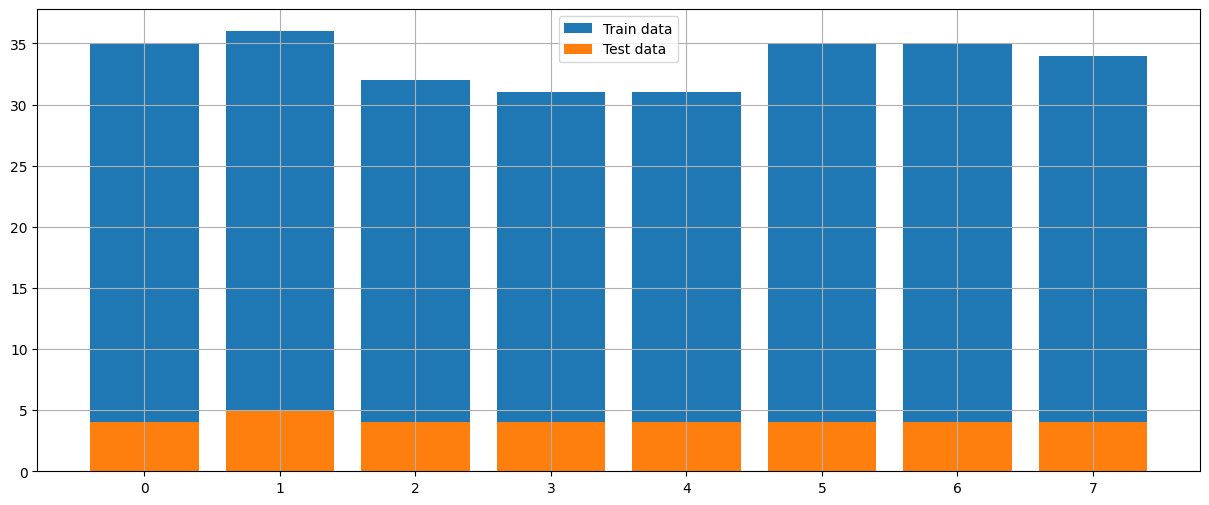

In [11]:
CLASSES, gems = [], [] 
for root, dirs, files in os.walk('gemstones'):
    f = os.path.basename(root)        
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f)
    
gems_count = len(CLASSES)
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
    plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend()

In [12]:
img_w, img_h = 220, 220    # width and height of image
train_dir = 'gemstones/train/'

In [13]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)    
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

In [14]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

In [15]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (269, 330, 330, 3)
Shape of train labels: (269,)


In [19]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           
            new_img = cv2.resize(new_img,(img_w, img_h))  
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [20]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)   

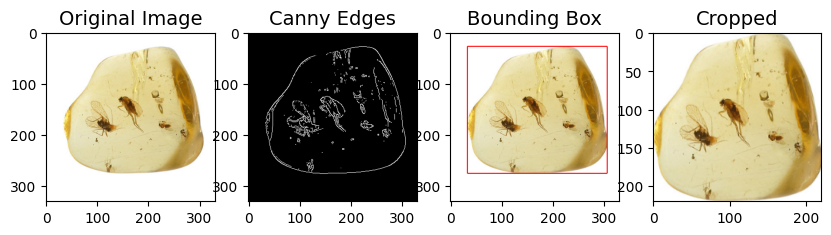

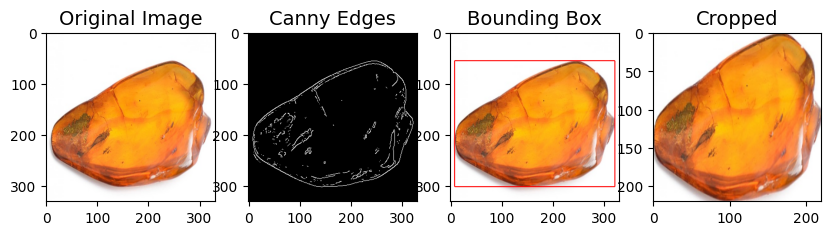

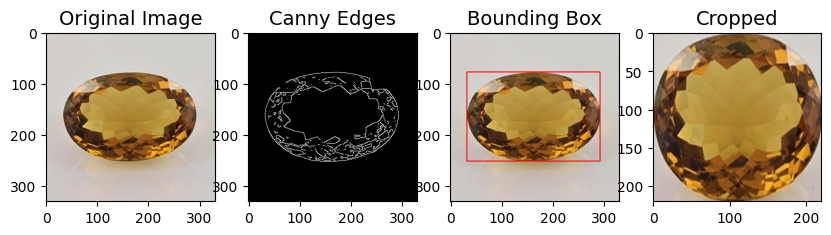

In [22]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

In [25]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [26]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (269, 220, 220, 3) 


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (215, 220, 220, 3), y_train: (215,) 
Shape of X_val: (54, 220, 220, 3), y_val: (54,) 


In [28]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

2025-02-08 18:43:30.892970: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-08 18:43:30.995693: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-08 18:43:31.080998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739020411.152149   85539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739020411.173611   85539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 18:43:31.350328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11753955632060144263
xla_global_id: -1
]


2025-02-08 18:43:34.262625: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [29]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [30]:
filters = 32
kernel_size = 3   
max_pool = 2      

In [31]:
EPOCHS = 70                                  
batch_size = 32                               
iter_per_epoch = len(X_train) // batch_size  
val_per_epoch = len(X_val) // batch_size     

In [34]:
model = Sequential()

# first 
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features

# second 
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 

# third 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

# fourth 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

# fifth 
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(87, activation='softmax'))

In [35]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(           
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()             

* the original image + examples of work of `ImageDataGenerator`: 

Text(0.5, 1.0, 'Original')

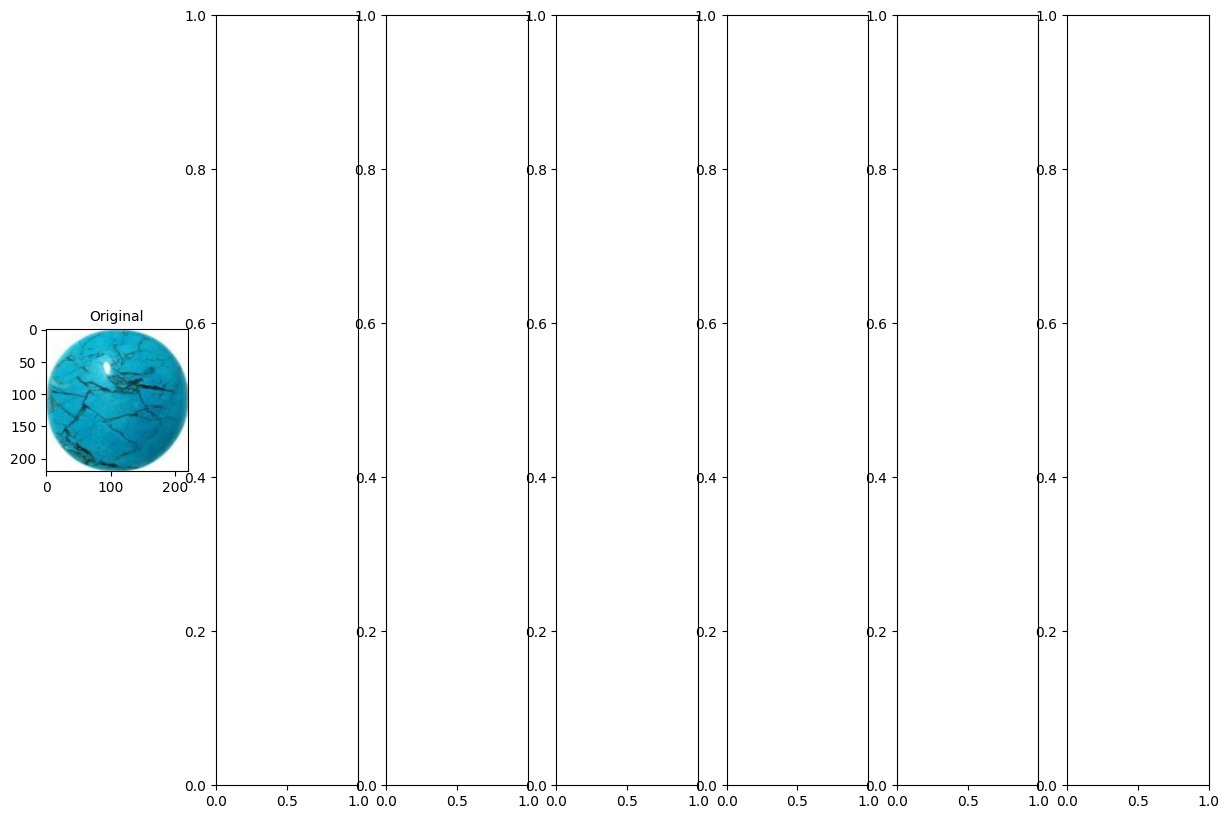

In [39]:
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7

fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

# for i in range(1,cols):
#     batch = it.next()    
#     image = batch[0].astype('uint32') 
#     ax[i].set_title('augmented {}'.format(i), fontsize=10)
#     ax[i].imshow(image, cmap='gray')

Create two numpy array iterators `train_gen` and `val_gen` and fill them with additional images:

In [40]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [42]:
m = model.fit(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
       )

/home/blue/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70


2025-02-08 18:52:44.616893: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 142489600 exceeds 10% of free system memory.
2025-02-08 18:52:44.715318: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35622400 exceeds 10% of free system memory.
2025-02-08 18:52:44.734367: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 71244800 exceeds 10% of free system memory.
2025-02-08 18:52:44.835539: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35622400 exceeds 10% of free system memory.
2025-02-08 18:52:45.064292: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35622400 exceeds 10% of free system memory.


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1426 - loss: 17.1778 - val_accuracy: 0.3750 - val_loss: 2.6725
Epoch 2/70
1/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3438 - loss: 2.4761

2025-02-08 18:52:55.037723: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3438 - loss: 2.4761 - val_accuracy: 0.4545 - val_loss: 2.0002
Epoch 3/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5050 - loss: 1.4138
Epoch 4/70


2025-02-08 18:53:03.858912: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6562 - loss: 0.7228 - val_accuracy: 0.5000 - val_loss: 1.3923
Epoch 5/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6184 - loss: 1.0134 - val_accuracy: 0.6818 - val_loss: 1.0246
Epoch 6/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6250 - loss: 0.6527
Epoch 7/70


2025-02-08 18:53:15.404642: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7044 - loss: 0.6196 - val_accuracy: 0.6875 - val_loss: 0.9956
Epoch 8/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7812 - loss: 0.4629 - val_accuracy: 0.7727 - val_loss: 0.6286
Epoch 9/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7356 - loss: 0.5025
Epoch 10/70
1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8750 - loss: 0.3198

2025-02-08 18:53:35.149007: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8750 - loss: 0.3198 - val_accuracy: 0.9062 - val_loss: 0.3577
Epoch 11/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8044 - loss: 0.4250 - val_accuracy: 0.7727 - val_loss: 0.4947
Epoch 12/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.4916
Epoch 13/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9110 - loss: 0.2863 - val_accuracy: 0.8438 - val_loss: 0.2390
Epoch 14/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9375 - loss: 0.1904 - val_accuracy: 0.8636 - val_loss: 0.4239
Epoch 15/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8511 - loss: 0.3639
Epoch 16/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9375 - loss: 0.2275 - val_accuracy: 0.9062 - val_loss: 0.2180
Epoch 17/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8835 - loss: 0.3379 - val_accuracy: 0.8182 - val_loss: 0.5983
Epoch 18/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8125 - loss: 0.3454
Epoch 19/70
6/

2025-02-08 18:54:28.006405: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8438 - loss: 0.4866 - val_accuracy: 0.7727 - val_loss: 0.6783
Epoch 21/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8546 - loss: 0.4187
Epoch 22/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8438 - loss: 0.5892 - val_accuracy: 0.7500 - val_loss: 0.5357
Epoch 23/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8453 - loss: 0.4285 - val_accuracy: 0.8182 - val_loss: 0.3953
Epoch 24/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2364
Epoch 25/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8324 - loss: 0.3800 - val_accuracy: 0.9062 - val_loss: 0.3451
Epoch 26/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8438 - loss: 0.4970 - val_accuracy: 0.8636 - val_loss: 0.2847
Epoch 27/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8892 - loss: 0.3356
Epoch 28/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7826 - loss: 0.4816 - val_accuracy: 0.9062 - val_loss: 0.3013
Epoch 29/70
6

2025-02-08 18:56:07.559818: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7812 - loss: 0.3823 - val_accuracy: 0.8438 - val_loss: 0.2660
Epoch 41/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8567 - loss: 0.4036 - val_accuracy: 0.9091 - val_loss: 0.2931
Epoch 42/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2989
Epoch 43/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8819 - loss: 0.2683 - val_accuracy: 0.9062 - val_loss: 0.3046
Epoch 44/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9375 - loss: 0.1602 - val_accuracy: 0.9545 - val_loss: 0.1161
Epoch 45/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8792 - loss: 0.3086
Epoch 46/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9130 - loss: 0.1509 - val_accuracy: 0.9062 - val_loss: 0.2161
Epoch 47/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9195 - loss: 0.2811 - val_accuracy: 0.8182 - val_loss: 0.2767
Epoch 48/70
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.2138
Epoch 49/70
6/

Check the accuracy

* plot the accuracy of model against size of epoch (train and val);
* plot the loss of model against size of epoch (train and val).

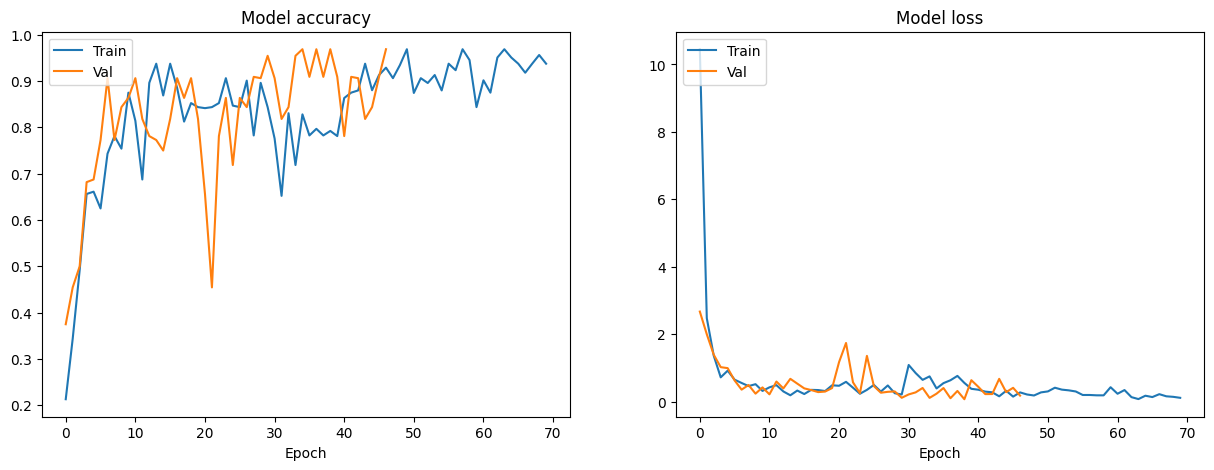

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')